In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

In [123]:
import azureml.core
from azureml.core.authentication import InteractiveLoginAuthentication
interactive_auth = InteractiveLoginAuthentication(tenant_id="dadbf9da-3f3b-44a8-8097-f3512ff34da8")
from azureml.core import Workspace
ws = Workspace.from_config(auth=interactive_auth)
print('azureml version', azureml.core.VERSION)
print('Connected to Workspace',
  '-- name: ' + ws.name,
  '-- Azure region: ' + ws.location,
  '-- Resource group: ' + ws.resource_group,
  sep = '\n')
datastore = ws.get_default_datastore()

azureml version 1.33.0
Connected to Workspace
-- name: fin-ws-wus2
-- Azure region: westus2
-- Resource group: fin-research


# Loading packages

In [124]:
import numpy as np
import os
import sys
import time
import pandas as pd 
from azureml.core.datastore import Datastore
from azureml.core.dataset import Dataset
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In this project, the goal is to use trades and quotes data and predict the profitibility of an investment in any point in time.

# Input Data

### Loading input datasets

In [125]:
ds_path = "../../data/datasets/"
ds_dict = {}
data_samples = {
    "trades_sample": "datasets/trades_raw/2018-08-14.csv.gz",
    "quotes_sample": "datasets/quotes_raw/corrected/2018-08-14.csv.gz",
}

for ds_name, path in data_samples.items():
    dataset = Dataset.File.from_files((datastore, path), validate=True)
    r = dataset.download(target_path=os.path.join(ds_path, ds_name), overwrite=True)
    ds_dict[ds_name] = r[0]

Here is a peak into the raw data:

In [126]:
trades_df = pd.read_csv(ds_dict["trades_sample"], compression="gzip")
print(trades_df.shape)
trades_df.head()

(142285, 10)


,#RIC,Alias Underlying RIC,Domain,Date-Time,Type,Price,Volume,Seq. No.,Exch Time,Acc. Volume
0,ESH9,NaN,Market Price,2018-08-14T09:04:25.040923352-05,Trade,2840.00,1.0,27243676,14:04:25.033000000,1.0
1,ESH9,NaN,Market Price,2018-08-14T13:18:10.868953997-05,Trade,2852.00,1.0,27303980,18:18:10.860000000,2.0
2,ESH9,NaN,Market Price,2018-08-14T14:07:34.007703853-05,Trade,NaN,NaN,7438719,NaN,102.0
3,ESH9,NaN,Market Price,2018-08-14T15:19:57.697107574-05,Trade,2851.75,NaN,7719574,NaN,102.0
4,ESM9,NaN,Market Price,2018-08-14T15:19:57.699000250-05,Trade,2859.00,NaN,7719572,NaN,NaN


In [127]:
quotes_df = pd.read_csv(ds_dict["quotes_sample"], compression="gzip")
print(quotes_df.shape)
quotes_df.head()

(2112044, 11)


,#RIC,Alias Underlying RIC,Domain,Date-Time,Type,Bid Price,Bid Size,Ask Price,Ask Size,Seq. No.,Exch Time
0,ESH9,NaN,Market Price,2018-08-14T00:00:54.271853955-05,Quote,2840.00,2.0,2841.75,1.0,4649983,05:00:54.264000000
1,ESH9,NaN,Market Price,2018-08-14T00:00:54.272314332-05,Quote,2839.75,3.0,2841.75,1.0,4650025,05:00:54.264000000
2,ESH9,NaN,Market Price,2018-08-14T00:00:54.272314332-05,Quote,2839.75,2.0,2841.75,1.0,4650045,05:00:54.265000000
3,ESH9,NaN,Market Price,2018-08-14T00:00:56.891950416-05,Quote,2839.75,2.0,2841.50,1.0,4650184,05:00:56.887000000
4,ESH9,NaN,Market Price,2018-08-14T00:00:56.895923392-05,Quote,2839.50,3.0,2841.50,1.0,4650248,05:00:56.887000000


# Data Preprocessing
We do a series of data procesing before using the data for training. Here is a list of data transformations. Later, we try to peak into these steps and display some data samples.

### Round 1
1. Filter out the unwanted contracts. This is taken from a table that is processed separately (HAR Monthly). This table indicated the main contract for each month.
2. Dropping unwanted columns

3. Data clean up

    a. remove trades with negative value or volume

4. Merge simultaneous data points into a larger trade
5. Add standardized "Daily Volatality" data from the HAR table. use '1' if not available. 
2. Recalculate the Accumulated Volume based on trades (i.e. ignore the one in the data)

In [128]:
# ds_path = "../../data/datasets/"
# ds_dict = {}
data_samples = {
    "trades_merged_sample": "datasets/trades_merged_mp/2018-08-14-mt.csv",
    "quotes_merged_sample": "datasets/quotes_merged_mp/2018-08-14-mt.csv",
    "HAR":"datasets/har/RV_Erfan.csv"
}

for ds_name, path in data_samples.items():
    dataset = Dataset.File.from_files((datastore, path), validate=True)
    r = dataset.download(target_path=os.path.join(ds_path, ds_name), overwrite=True)
    ds_dict[ds_name] = r[0]

This is the table Erfan generated that has the daily volatality.

In [129]:
har_df = pd.read_csv(ds_dict["HAR"], compression="infer")
print(har_df.shape)
har_df[400:410]

(911, 18)


,Date[L],Open Price,Low Price,High Price,Close Price,Return,Log Return,Count,RV,Scaled RV,RV_W,RV_M,RV_M_Ahead,RV_D_Ahead,HAR 1-Month,HAR (Log RV) 1-Month,HAR 1-Day,HAR (Log RV) 1-Day
400,2018-08-09,2858.00,2852.25,2862.75,2853.50,-6.129061,-6.130940,81,1207.009748,1148.709211,1349.637948,2455.057459,3198.624738,4680.158642,2762.377504,3358.211438,5407.613740,1691.809669
401,2018-08-10,2837.00,2826.00,2843.00,2837.50,-56.071491,-56.229282,81,4917.691133,4680.158642,1978.470813,2553.567080,3106.635880,4286.656060,4803.390178,5256.347178,5921.958140,3792.156925
402,2018-08-13,2837.00,2820.00,2843.75,2825.75,-41.409692,-41.495667,81,4504.217081,4286.656060,2595.063054,2681.725543,3085.093852,2447.030581,4687.770234,5462.760404,5888.816152,3933.029468
403,2018-08-14,2831.00,2826.75,2843.50,2841.25,54.852694,54.702801,81,2571.224933,2447.030581,2802.017470,2711.424886,3073.648889,8069.563227,3710.176385,4806.967511,5633.932994,3037.509156
404,2018-08-15,2825.25,2803.00,2826.75,2822.00,-67.751870,-67.982428,81,8479.118459,8069.563227,4126.423544,2980.514712,2787.778815,2504.553141,6984.252101,7208.197128,6476.566901,6126.812527
405,2018-08-16,2834.75,2834.75,2851.75,2845.25,82.388377,82.050837,81,2631.666941,2504.553141,4397.592330,3049.932046,2752.877347,3108.084866,3969.374305,5390.679001,5702.920711,3479.592167
406,2018-08-17,2839.25,2835.00,2857.00,2852.50,25.481065,25.448656,81,3265.829763,3108.084866,4083.177575,3039.592793,2722.261924,1154.782711,4264.803610,5622.005634,5793.300650,3802.218359
407,2018-08-20,2856.75,2851.50,2860.75,2858.75,21.910605,21.886636,81,1213.391496,1154.782711,3456.802905,3017.431066,2763.403215,1536.606417,3108.016053,4188.738747,5525.201780,2240.658080
408,2018-08-21,2863.50,2861.00,2874.00,2861.00,7.870573,7.867477,81,1614.593933,1536.606417,3274.718072,3016.138448,2745.243774,2097.823341,3294.780048,4460.274928,5583.360556,2547.038915
409,2018-08-22,2859.50,2856.25,2868.25,2861.25,0.873820,0.873782,81,2204.294348,2097.823341,2080.370095,2927.845459,2703.123060,2398.356624,3424.864774,4366.479720,5662.843147,2643.593548


Trades table after merging simultaneous trades and recalculaing Acumulated Volume.

In [157]:
trades_merged_df = pd.read_csv(ds_dict["trades_merged_sample"], compression="infer")
print(trades_merged_df.shape)
trades_merged_df.head()

(94335, 6)


,Date-Time,Price,Volume,Seq. No.,Exch Time,Acc Volume
0,2018-08-14 00:00:00.010316234-05:00,2830.50,3.0,27197304,05:00:00.002000000,3.0
1,2018-08-14 00:00:06.421803611-05:00,2830.75,1.0,27197305,05:00:06.416000000,4.0
2,2018-08-14 00:00:11.782033615-05:00,2830.75,1.0,27197306,05:00:11.773000000,5.0
3,2018-08-14 00:00:11.802091895-05:00,2830.75,1.0,27197307,05:00:11.793000000,6.0
4,2018-08-14 00:00:11.870120483-05:00,2830.75,1.0,27197308,05:00:11.864000000,7.0


Quotes table after mergin simultaneous datapoints

In [158]:
quotes_merged_df = pd.read_csv(ds_dict["quotes_merged_sample"], compression="infer")
print(quotes_merged_df.shape)
quotes_merged_df.head()

(619686, 9)


,Date-Time,Bid Price,Ask Price,Bid Size,Ask Size,Seq. No.,Exch Time,#RIC,dailyVolatility
0,2018-08-14 00:00:00.010359754-05:00,2830.5,2830.75,277.0,170.0,4649622,05:00:00.002000000,ESU8,0.443103
1,2018-08-14 00:00:00.099343608-05:00,2830.5,2830.75,69.0,47.0,4649628,05:00:00.090000000,ESU8,0.443103
2,2018-08-14 00:00:00.259351160-05:00,2830.5,2830.75,138.0,98.0,4649631,05:00:00.250000000,ESU8,0.443103
3,2018-08-14 00:00:00.378437145-05:00,2830.5,2830.75,69.0,48.0,4649637,05:00:00.370000000,ESU8,0.443103
4,2018-08-14 00:00:00.482391556-05:00,2830.5,2830.75,69.0,47.0,4649639,05:00:00.474000000,ESU8,0.443103


### Round 2
1. limit the data to 8:30 - 15 time window
2. Add new features:

    a. Spread
    
    b. Mid Quote
    
    c. Smart Price
    
    d. Quote Imbalance
    
```Python
df_quotes["Spread"] = df_quotes["Ask Price"] - df_quotes["Bid Price"]
df_quotes["Mid Quote"] = (df_quotes["Ask Price"] + df_quotes["Bid Price"]) / 2
df_quotes["Smart Price"] = (
    df_quotes["Ask Price"] * (1 / df_quotes["Ask Size"])
    + df_quotes["Bid Price"] * (1 / df_quotes["Bid Size"])
    ) / (1 / df_quotes["Ask Size"] + 1 / df_quotes["Bid Size"])
df_quotes["Quote Imbalance"] = np.log(df_quotes["Ask Size"]) - np.log(df_quotes["Bid Size"])
```
    


## Finding bars
We use volume bars in this implementation. Here is the algorithm:
0-join trades and quotes to calculate direction

1. create a grid between min(Vol) and max(vol) with space equals paramters vol_tick (default to 1000)

2. find the index and time of the trade that is right afther the volume thresholds
3. find the quote data that is right before the selected trade
4. fora each tick point calcluate:
    1. Order Imbalance
    2. Close Price
    3. Avg Trade Size
    4. Net SellBuy Count
    
5. Add time weighted average of these paramters
6. add first derivitive features as new features
7. Add BidAsk Ratio feature
8. Add Tick duration (bar duration) to the data

## Calulating labels
The basic label columns are :
- "long_label"
- "long_return"
- "long_duration"
- "pt_long_ind"
- "sl_long_ind"
- "short_label"
- "short_return"
- "short_duration"
- "pt_short_ind"
- "sl_short_ind"
- "end_ind"
                
which are labeled with three different bar sizes ([0.5,1,1.5] * 0.0010*daily volatality)

In [159]:
# ds_path = "../../data/datasets/"
# ds_dict = {}
data_samples = {
    "bars_sample": "dataset/8dcbb452-f72f-45fd-89ee-74e723b5e781/bars_data_0_001_1000/bars_2018-08-14-mt.csv",
}

for ds_name, path in data_samples.items():
    dataset = Dataset.File.from_files((datastore, path), validate=True)
    r = dataset.download(target_path=os.path.join(ds_path, ds_name), overwrite=True)
    ds_dict[ds_name] = r[0]

In [160]:
bars_df = pd.read_csv(ds_dict["bars_sample"], compression="infer")
print(bars_df.shape)
print(bars_df.columns)
bars_df[400:410]

(759, 65)
Index(['Ask Price', 'Ask Size', 'Bid Price', 'Bid Size', 'Spread', 'Mid Quote',
       'Smart Price', 'Quote Imbalance', 'Ask Price_diff_1', 'Ask Size_diff_1',
       'Bid Price_diff_1', 'Bid Size_diff_1', 'Spread_diff_1',
       'Mid Quote_diff_1', 'Smart Price_diff_1', 'Quote Imbalance_diff_1',
       'TW Avg Ask Price', 'TW Avg Ask Size', 'TW Avg Bid Price',
       'TW Avg Bid Size', 'TW Avg Spread', 'TW Avg Mid Quote',
       'TW Avg Smart Price', 'TW Avg Quote Imbalance', 'dailyVolatility',
       'BidAskRatio', 'TW Avg BidAskRatio', 'tick_duration', 'Order Imbalance',
       'Close Price', 'Avg Trade Size', 'Net SellBuy Count', 'long_label_1',
       'long_return_1', 'long_duration_1', 'pt_long_ind_1', 'sl_long_ind_1',
       'short_label_1', 'short_return_1', 'short_duration_1', 'pt_short_ind_1',
       'sl_short_ind_1', 'end_ind_1', 'long_label_2', 'long_return_2',
       'long_duration_2', 'pt_long_ind_2', 'sl_long_ind_2', 'short_label_2',
       'short_return_2', 's

,Ask Price,Ask Size,Bid Price,Bid Size,Spread,Mid Quote,Smart Price,Quote Imbalance,Ask Price_diff_1,Ask Size_diff_1,...,long_return_3,long_duration_3,pt_long_ind_3,sl_long_ind_3,short_label_3,short_return_3,short_duration_3,pt_short_ind_3,sl_short_ind_3,end_ind_3
400,2840.25,1292.0,2840.00,129.0,0.25,2840.125,2840.022695,2.304134,0.25,1144.0,...,-0.25,0 days 00:10:00.897119972,NaN,NaN,0.0,0.25,0 days 00:10:00.897119972,NaN,NaN,241798.0
401,2839.25,146.0,2839.00,112.0,0.25,2839.125,2839.108527,0.265108,-1.00,-1146.0,...,1.00,0 days 00:10:00.102414946,NaN,NaN,0.0,-1.00,0 days 00:10:00.102414946,NaN,NaN,242308.0
402,2838.75,36.0,2838.50,275.0,0.25,2838.625,2838.721061,-2.033252,-0.50,-110.0,...,2.25,0 days 00:10:00.189663014,NaN,NaN,0.0,-2.25,0 days 00:10:00.189663014,NaN,NaN,242968.0
403,2838.00,204.0,2837.75,189.0,0.25,2837.875,2837.870229,0.076373,-0.75,168.0,...,3.00,0 days 00:10:00.009929815,NaN,NaN,-1.0,-3.00,0 days 00:09:33.714228164,NaN,242854.0,243354.0
404,2838.00,878.0,2837.75,80.0,0.25,2837.875,2837.770877,2.395620,0.00,674.0,...,3.00,0 days 00:10:00.041708045,NaN,NaN,-1.0,-3.00,0 days 00:09:25.689665004,NaN,242854.0,243431.0
405,2837.75,31.0,2837.50,283.0,0.25,2837.625,2837.725318,-2.211460,-0.25,-847.0,...,3.00,0 days 00:10:00.776677960,NaN,NaN,-1.0,-3.00,0 days 00:08:59.545155768,NaN,242751.0,243739.0
406,2837.75,190.0,2837.50,930.0,0.25,2837.625,2837.707589,-1.588161,0.00,159.0,...,3.25,0 days 00:10:00.001101334,NaN,NaN,-1.0,-3.00,0 days 00:08:26.713601414,NaN,242751.0,244253.0
407,2837.75,272.0,2837.50,1778.0,0.25,2837.625,2837.716829,-1.877442,0.00,82.0,...,3.25,0 days 00:10:00.073595626,NaN,NaN,-1.0,-3.00,0 days 00:08:04.753266050,NaN,242751.0,244564.0
408,2838.00,111.0,2837.75,314.0,0.25,2837.875,2837.934706,-1.039863,0.25,-161.0,...,3.00,0 days 00:10:00.039167828,NaN,NaN,-1.0,-3.00,0 days 00:07:26.721893047,NaN,242854.0,245254.0
409,2838.00,15.0,2837.75,308.0,0.25,2837.875,2837.988390,-3.022050,0.00,-96.0,...,2.75,0 days 00:10:00.141683661,NaN,NaN,-1.0,-3.00,0 days 00:06:52.885056509,NaN,242854.0,245613.0


Here is another view with only basic columns

In [279]:
basic_cols = ['Ask Price', 'Ask Size', 'Bid Price', 'Bid Size', 'Spread', 'Mid Quote',
       'Smart Price', 'Quote Imbalance', 'dailyVolatility',
       'BidAskRatio', 'TW Avg BidAskRatio', 'tick_duration', 'Order Imbalance',
       'Close Price', 'Avg Trade Size', 'Net SellBuy Count', 'long_label_2',
       'long_return_2', 'long_duration_2']
bars_df[400:410][basic_cols]

,Ask Price,Ask Size,Bid Price,Bid Size,Spread,Mid Quote,Smart Price,Quote Imbalance,dailyVolatility,BidAskRatio,TW Avg BidAskRatio,tick_duration,Order Imbalance,Close Price,Avg Trade Size,Net SellBuy Count,long_label_2,long_return_2,long_duration_2
400,2840.25,1292.0,2840.00,129.0,0.25,2840.125,2840.022695,2.304134,0.730927,0.099845,0.494767,0 days 00:01:14.807818800,-6473121.0,2840.000000,538949.130769,1.203390,-1.0,-2.00,0 days 00:01:48.916955953
401,2839.25,146.0,2839.00,112.0,0.25,2839.125,2839.108527,0.265108,0.730927,0.767123,0.512199,0 days 00:00:46.631897675,-14054446.0,2839.000000,540080.092308,1.500000,0.0,1.00,0 days 00:10:00.102414946
402,2838.75,36.0,2838.50,275.0,0.25,2838.625,2838.721061,-2.033252,0.730927,7.638889,0.994911,0 days 00:00:44.728795854,-1075903.0,2838.750000,540997.246032,1.032258,0.0,2.25,0 days 00:10:00.189663014
403,2838.00,204.0,2837.75,189.0,0.25,2837.875,2837.870229,0.076373,0.730927,0.926471,0.947824,0 days 00:00:21.415484546,3249218.0,2837.605292,541786.052632,0.853659,1.0,2.50,0 days 00:08:30.575765951
404,2838.00,878.0,2837.75,80.0,0.25,2837.875,2837.770877,2.395620,0.730927,0.091116,1.076816,0 days 00:00:08.024563160,-10862286.0,2837.750000,543059.571429,1.800000,1.0,2.50,0 days 00:08:22.551202791
405,2837.75,31.0,2837.50,283.0,0.25,2837.625,2837.725318,-2.211460,0.730927,9.129032,1.090445,0 days 00:00:21.400510475,-1093231.0,2837.750000,543898.932692,1.039216,1.0,2.50,0 days 00:07:09.184391071
406,2837.75,190.0,2837.50,930.0,0.25,2837.625,2837.707589,-1.588161,0.730927,4.894737,0.997487,0 days 00:00:32.831554354,-2723953.0,2837.750000,544924.174603,1.172414,1.0,2.50,0 days 00:06:36.352836717
407,2837.75,272.0,2837.50,1778.0,0.25,2837.625,2837.716829,-1.877442,0.730927,6.536765,0.921322,0 days 00:00:21.960335364,3825994.0,2837.750000,545934.689655,0.851064,1.0,2.50,0 days 00:06:14.392501353
408,2838.00,111.0,2837.75,314.0,0.25,2837.875,2837.934706,-1.039863,0.730927,2.828829,0.827630,0 days 00:00:42.775371764,-3830566.0,2838.000000,547057.527273,1.291667,1.0,2.50,0 days 00:06:23.583430834
409,2838.00,15.0,2837.75,308.0,0.25,2837.875,2837.988390,-3.022050,0.730927,20.533333,1.549908,0 days 00:00:33.836836538,25755506.0,2837.750000,547937.831776,0.389610,1.0,2.50,0 days 00:05:49.746594296


Let's do some visualization:

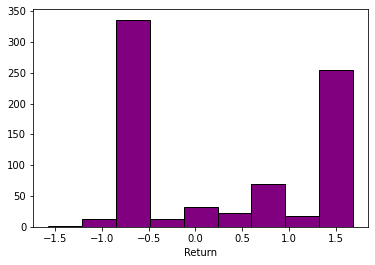

In [44]:
# hist = bars_df["long_return_1"].hist(bins=20, xlabel ="return")
fig, ax = plt.subplots()
plt.hist(bars_df["long_return_1"], bins=9, align='right', color='purple', edgecolor='black');
ax.set_xlabel("Return");

And let's visualize some labels. The stored bars data is missing Date-Time, so, here we'll add that column. I'll update the code to keep it from now on.

In [282]:
# Recalculating and adding time stamps to bars
from datetime import datetime, timedelta
def trim_df_to_time(df, start_str, end_str):
    df["Time"] = df.loc[:, "Date-Time"].apply(lambda x: str(x)[11:-10])
    df["Time"] = pd.to_datetime(df["Time"], format="%H:%M:%S.%f")
    print("full df shape", df.shape)
    df = df[df["Time"] >= datetime.strptime(start_str, "%H:%M:%S.%f")]
    print(">8:30  df shape", df.shape)
    df = df[df["Time"] <= datetime.strptime(end_str, "%H:%M:%S.%f")]
    print("time-trimmed df shape", df.shape)
    df.reset_index(inplace=True, drop=True)

    df["Date-Time"] = pd.to_datetime(df["Date-Time"])
    return df
# Trim dataframes to working hours
quotes_merged_df = trim_df_to_time(quotes_merged_df, "8:30:00.00", "15:00:00.00")
trades_merged_df = trim_df_to_time(trades_merged_df, "8:30:00.00", "15:00:00.00")


vol_tick = 1000
vol = trades_merged_df["Acc Volume"]
vol_tick = vol_tick
vol_levels = range(int(min(vol)) + vol_tick, int(max(vol)), vol_tick)
vol_levels
tick_times = []
# Find the trade right after the volume tick
for level in vol_levels:
    ind = vol[vol > level].index.min()
    tick_times.append(trades_merged_df.loc[ind, "Date-Time"])
print("The tick_times for ticks(5):\n {}".format(tick_times[:5]))

times = quotes_merged_df["Date-Time"]
inds = []

#Fime the qoute right before the trade tick
for tick_time in tick_times:
    ind = times[times < tick_time].index.max()
    inds.append(ind)

inds = [x for x in inds if x > 0]

# Adding the time stamps to bars_df
bars_df["Date-Time"]= tick_times[:-1]

full df shape (415967, 10)
>8:30  df shape (415967, 10)
time-trimmed df shape (415967, 10)
full df shape (67315, 7)
>8:30  df shape (67315, 7)
time-trimmed df shape (67315, 7)
The tick_times for ticks(5):
 [Timestamp('2018-08-14 08:30:00.691565911-0500', tz='pytz.FixedOffset(-300)'), Timestamp('2018-08-14 08:30:03.513581377-0500', tz='pytz.FixedOffset(-300)'), Timestamp('2018-08-14 08:30:12.347604982-0500', tz='pytz.FixedOffset(-300)'), Timestamp('2018-08-14 08:30:15.071608617-0500', tz='pytz.FixedOffset(-300)'), Timestamp('2018-08-14 08:30:36.039052670-0500', tz='pytz.FixedOffset(-300)')]


Now that we have all datasets with time stamps, we can plot some labels

In [283]:
# Let's pick a subset of the day time for cleaner plots
start_time = bars_df.iloc[400]["Date-Time"]
end_time = bars_df.iloc[440]["Date-Time"]
start_time

Timestamp('2018-08-14 10:52:36.514388315-0500', tz='pytz.FixedOffset(-300)')

In [284]:
# Let's trim the data TODO: Use the trim method from above
quotes_merged_df["Date-Time"] = pd.to_datetime(quotes_merged_df["Date-Time"])
trimmed_quotes_merged_df = quotes_merged_df[quotes_merged_df['Date-Time']>start_time]
trimmed_quotes_merged_df = trimmed_quotes_merged_df[trimmed_quotes_merged_df['Date-Time']<end_time]
trimmed_bars_df = bars_df[bars_df['Date-Time']>=start_time]
trimmed_bars_df = trimmed_bars_df[trimmed_bars_df['Date-Time']<=end_time]

In [285]:
print("Number of quotes data points: {}\nNumber of bars data point: {} ".format(len(trimmed_quotes_merged_df), len(trimmed_bars_df)))

Number of quotes data points: 25158
Number of bars data point: 41, 


In [288]:
def plot_barriers(merged_df, i, df, pt_level=0.0001, sl_level=0.0001, end_ind_label="ind_ind"):
    # Color coding the labels, loss : red  , no-hot: black,  gain: blue
    c=['r','k','b'][int(df.loc[i,'long_label_2'])+1]
    max_ind = merged_df.index.max()
    end_ind=min(int(df.loc[i,end_ind_label]),max_ind)
    plt.hlines(df.loc[i,'Ask Price']*np.array([1+df.loc[i,'dailyVolatility']*pt_level,1-df.loc[i,'dailyVolatility']*sl_level]), xmin=df.loc[i,'Date-Time'], xmax=merged_df.loc[end_ind,'Date-Time'], color=c, linestyles='--')
    plt.vlines(x = [df.loc[i,'Date-Time'], merged_df.loc[end_ind,'Date-Time']], ymin=df.loc[i,'Ask Price']*(1-df.loc[i,'dailyVolatility']*sl_level), ymax=df.loc[i,'Ask Price']*(1+df.loc[i,'dailyVolatility']*pt_level), color=c, linestyles='--')
#     plt.text(df.loc[i,'Date-Time'],df.loc[i,'Bid Price']+2,i )
# plot_barriers(i, bars_df)

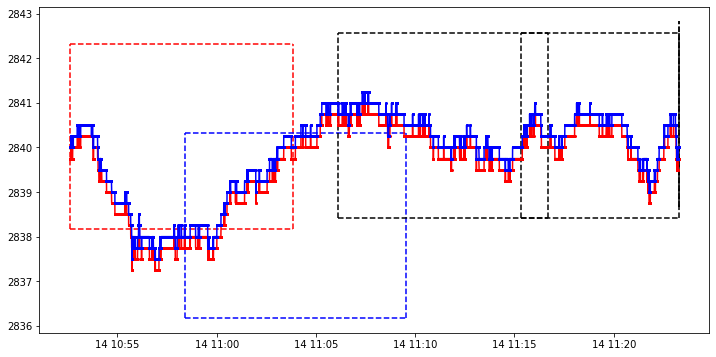

In [289]:
fig, ax = plt.subplots(figsize=(12, 6))


ax.plot(trimmed_quotes_merged_df['Date-Time'], trimmed_quotes_merged_df['Bid Price'], "-ro", markersize=2)
ax.plot(trimmed_quotes_merged_df['Date-Time'], trimmed_quotes_merged_df['Ask Price'], "-bo", markersize=2)
for i in trimmed_bars_df.index:
    # plotting every 10th label for a cleaner plot
    if i%10 ==0:
        plot_barriers(trimmed_quotes_merged_df, i, bars_df, pt_level=0.001, sl_level=0.001, end_ind_label="end_ind_2")
# plugins.connect(fig, plugins.MousePosition(fontsize=14))

# mpld3.display();

In [221]:
tick_times[400]

Timestamp('2018-08-14 10:52:36.514388315-0500', tz='pytz.FixedOffset(-300)')

In [104]:
quotes_merged_df.iloc[630,:]

Date-Time          2018-08-14 08:30:03.479352879-05:00
Bid Price                                      2831.25
Ask Price                                       2831.5
Bid Size                                           116
Ask Size                                           184
Seq. No.                                       5445548
Exch Time                           13:30:03.473000000
#RIC                                              ESU8
dailyVolatility                               0.443103
Time                        1900-01-01 08:30:03.479350
Name: 630, dtype: object

# Loading datasets

In [17]:
ds_path = "../../data/datasets/"
ds_dict = {
    "train_dataset_x": "",
    "train_dataset_y": "",
    "train_dataset_w": "",
    "test_dataset_x": "",
    "test_dataset_y": "",
    "test_dataset_w": "",
}
for ds_name in ds_dict:
    dataset = Dataset.get_by_name(ws, name=ds_name)
    r = dataset.download(target_path=ds_path, overwrite=True)
    ds_dict[ds_name] = r[0]

In [18]:
ds_dict

{'train_dataset_x': 'C:\\Git\\fin_research\\data\\datasets\\X_train_data.npy',
 'train_dataset_y': 'C:\\Git\\fin_research\\data\\datasets\\y_1_train_data.npy',
 'train_dataset_w': 'C:\\Git\\fin_research\\data\\datasets\\w_train_data.npy',
 'test_dataset_x': 'C:\\Git\\fin_research\\data\\datasets\\X_test_data.npy',
 'test_dataset_y': 'C:\\Git\\fin_research\\data\\datasets\\y_1_test_data.npy',
 'test_dataset_w': 'C:\\Git\\fin_research\\data\\datasets\\w_test_data.npy'}

In [19]:
X_test = np.load(ds_dict["test_dataset_x"])
y_test_all = np.load(ds_dict["test_dataset_y"])
y_test = y_test_all[:,0].reshape(len(y_test_all))
ret_test = y_test_all[:,1].reshape(len(y_test_all))
hold_test = y_test_all[:,2].reshape(len(y_test_all))
y_test+=1
w_test = np.load(ds_dict["test_dataset_w"])
w_test = w_test.reshape(len(w_test))

print(
    " X_test {}, y_test {}, w_test {}".format(
         X_test.shape, y_test.shape, w_test.shape
    )
)

 X_test (206743, 62), y_test (206743,), w_test (206743,)


In [20]:
from collections import Counter
Counter(y_test)

Counter({1.0: 18068, 0.0: 107359, 2.0: 81316})

# Loading the models
here we list all the registered models. The format of the model name is:
{algorithm name}_{time_steps}_{task: classification | regression}

In [21]:
from azureml.core import Model
from joblib import dump, load
model_dict = {}
downloade_models_path = 'downloaded_models'
print("Full list of registered models:")

# TODO: add a tag for model perf
for model in Model.list(ws):
    # Get model name and auto-generated version
    if (model.name not in model_dict) or ((model.name not in model_dict) and (model.version > model_dict[model.name])):
        model_dict[model.name]=model
        print(model.name, 'version:', model.version)
            
    
os.makedirs(downloade_models_path, exist_ok=True)

Full list of registered models:
LR_20_clf_w version: 1
LinearRegression_20_reg_w version: 1
LinearRegression_10_reg_w version: 1
LinearRegression_5_reg_w version: 1
LinearRegression_5_reg version: 1
LinearRegression_1_reg version: 2
LR_1_clf version: 1
mnist-prs version: 3


In [22]:
# pick the model you are interested in model_dict["model_name"]
# format {name}_{timesteps}_{task: classifiaction|regression}
model_name = "LR_1_clf"


model = model_dict[model_name]
task = model_name.split("_")[2]
print(model)
model_path = model.download(downloade_models_path, exist_ok=True)
model = load(model_path)

Model(workspace=Workspace.create(name='fin-ws-wus2', subscription_id='63a4bc7f-cd60-49a3-b139-49202d485eac', resource_group='fin-research'), name=LR_1_clf, id=LR_1_clf:1, version=1, tags={'data-format': '2d array'}, properties={})


c:\users\amah\.conda\envs\shrikedev\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## Preparing data for infernece
`time_steps` defines how many samples are used for each training round. We can use data at time t0 to predict result at time t0,or we can include n previous data points as well, in that case, time steps is equal n.
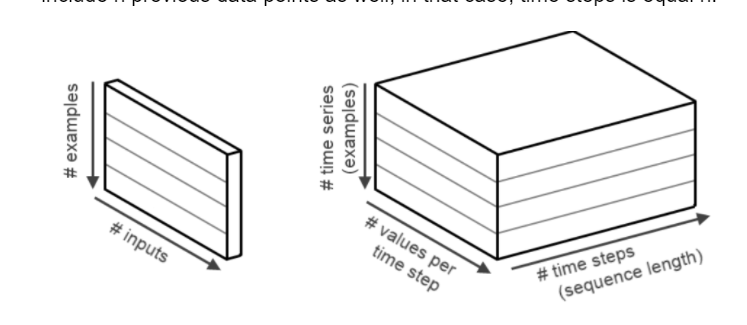

so, the training data can be a sequence and hence 3d. 
Weights and labels are 1d

In [12]:
# Set the time steps according to your model
# how many previous samples you include in your training of each label?
time_steps = 1

In [13]:
sys.path.insert(0, '../src/utils')
from data_utils import build_timeseries

X_test_3d, y_test_1d, w_test_1d = build_timeseries(X_test, y_test, steps = time_steps, weights=w_test) 
ret_test_1d = ret_test[time_steps:]
w_test_1d = w_test[time_steps:]
hold_test_1d = hold_test[time_steps:]


X_test_2d = X_test_3d.reshape(X_test_3d.shape[0],X_test_3d.shape[1]*X_test_3d.shape[2])


print(
    "X_test_2d {}, y_test_2d {}".format(
         X_test_2d.shape, y_test_1d.shape
    )
)

dim_0 206742
length of time-series i/o (206742, 1, 62) (206742,)
X_test_2d (206742, 62), y_test_2d (206742,)


# Simulation Functions

In [14]:
y_pred_flat = model.predict(X_test_2d)
if task == "reg":
    y_pred_bid =[1 if y>0 else 0 for y in y_pred_flat]
    y_test_1d_bid = [1 if y>0 else 0 for y in y_test_1d]
    labels={'loss':0,'gain':1}
    print(classification_report(y_test_1d_bid, y_pred_bid, target_names=labels.keys()))
    
else:
    y_pred_bid =y_pred_flat
    y_test_1d_bid = y_test_1d
    cm = confusion_matrix(y_test_1d, y_pred_flat)
    labels={'loss':0,'no hit':1,'gain':2}
    print("{} gain precision: {:.2f}".format(model_name, cm[2,2]/sum(cm[:,2])))
    print(classification_report(y_test_1d, y_pred_flat, target_names=labels.keys()))


LR_1_clf gain precision: 0.40
              precision    recall  f1-score   support

        loss       0.54      0.56      0.55    107359
      no hit       0.22      0.14      0.17     18067
        gain       0.40      0.42      0.41     81316

    accuracy                           0.47    206742
   macro avg       0.39      0.37      0.38    206742
weighted avg       0.46      0.47      0.46    206742



## Strategy functions:
define your own strategy function and test your perf

In [ ]:
from enum import Enum
class BindState(Enum):
    CASH=1
    LONG=2
    SHORT=0
    
def single_unit_trade(y_pred, ret, hold_duration, bar_duration, labels={'loss':0,'no hit':1,'gain':2} ):
    ret_sum = 0
    hold_time = 0
    bar_separation = 0
    number_of_trades=0
    state=BindState.CASH
    for i,pred in enumerate(y_pred):
        if state==BindState.LONG:
            bar_separation +=bar_duration[i]
            if bar_separation>= hold_time:
                state=BindState.CASH
                
        if state==BindState.CASH and pred==labels['gain']:
                number_of_trades+=1
                state=BindState.LONG
                hold_time = hold_duration[i]
                ret_sum+=ret[i]
    return ret_sum, number_of_trades 

In [ ]:
single_unit_trade(y_pred_bid, ret_test_1d, hold_test_1d, w_test_1d, labels=labels)